In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Objective

Our goal is to develop a model for predicting the likelihood of future payment defaults from a roster of current and prospective clients. Initially we would like to develop an understanding of the relationship between what we know about our clients (i.e. income statement, balance sheet, credit history, etc.) and their corresponding frequency of missed payment and serious delinquency.

In [3]:
df = pd.read_excel('Dataset Project 1.xlsx', header=1)

In [4]:
df.describe(percentiles=[0.25, 0.5, 0.75])

,Age,Monthly Revenue,Debt Ratio,Rated Exposure,# Overdue 30-59 Days,# Overdue 60-89 Days,# Overdue 90+ Days,Serious Delinquencies in past 2 years
count,45063.000,36420.000,45063.000,43946.000,45063.000,45063.000,45063.000,45063.000
mean,51.211,6452.263,352.063,0.790,0.751,0.506,0.571,0.222
std,14.652,12638.168,2467.556,1.131,6.185,6.154,6.173,0.416
min,21.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,40.000,3286.000,0.176,0.000,0.000,0.000,0.000,0.000
50%,51.000,5166.000,0.374,0.000,0.000,0.000,0.000,0.000
75%,62.000,8000.000,0.857,1.000,0.000,0.000,0.000,0.000
max,107.000,1794060.000,326442.000,10.000,98.000,98.000,98.000,1.000


# Some general observations about the data

<p>The dataset represents 45,063 clients, ranging in age from 21 to 107 (months, presumably).</p>

## Age

The age metric is perhaps the feature of our dataset with the most normal distribution, with a positive skew of just 0.245.

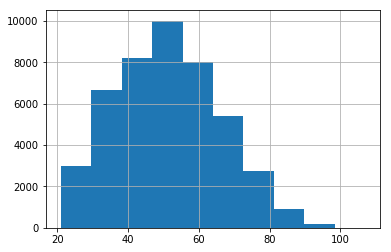

In [5]:
df['Age'].hist(bins=10)

## Monthly Revenue

For 8,643 clients, no revenue figure is given. Of the 36,420 for which revenue is reported, the distribution shows a **positive skew** (nonparametric skew of 0.102), with 85.9% having less than \$10,000 and 98.4% having less than \$20,000. Only 18 have revenue in excess of \$100,000, and 477 report zero revenue. See below for a histographic distribution of the revenues under \$20,000.

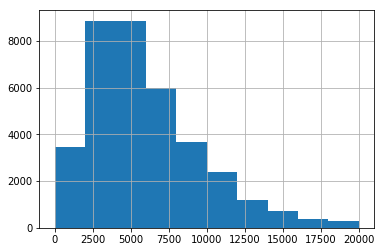

In [6]:
rev_col = df.columns[1]
temp = df[df[rev_col]<=20000]
temp[rev_col].hist(bins=10)

## Debt Ratio

As with the monthly revenues, the debt ratio statistic reflects a definite positive skew with 33,332 companies reporting a debts to assets ratio betwen 0 and 1. 1,286 report no debt at all, and 59 outliers have ratios in excess of 10,000.

In [7]:
debt_ratio_col = df.columns[2]

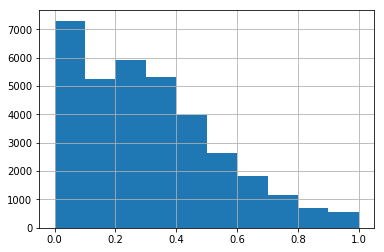

In [9]:
#distribution of companies with debt ratio between 0 and 1 inclusive

temp = df[df[debt_ratio_col]<=1]
temp[debt_ratio_col].hist(bins=10)

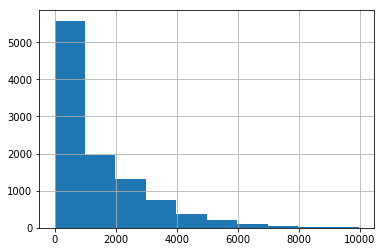

In [10]:
# distribution of companies with debt ratio between 1 and 10,000

temp = df[(df[debt_ratio_col]>1) & (df[debt_ratio_col]<10000)]
temp[debt_ratio_col].hist(bins=10)

## Rated Exposure

1,117 clients have no credit rating in the dataset, and it should be noted that the monthly revenue is also missing in each of those cases. Of the 43,946 that do show a credit rating, 58% have a rating of 0. As the rating increases, the number of companies assigned the given rating decrease monotonically.

As the rating increases, the average revenue of the client tends to increase and the average debt ratio tends to decrease, at least for the ratings held by a significant number of clients (<= 6): the Pearson correlation coefficients when comparing average revenues and debt ratios for such clients are 0.954 and -0.694 respectively.

In [11]:
df[df['Rated Exposure']>=0].shape

(43946, 8)

In [12]:
df['Rated Exposure'].value_counts()

0.000     25509
1.000      8106
2.000      6071
3.000      3004
4.000       951
5.000       226
6.000        57
7.000        14
8.000         6
10.000        1
9.000         1
Name: Rated Exposure, dtype: int64

In [13]:
grouped = df.groupby('Rated Exposure').mean()[['Monthly Revenue', 'Debt Ratio']]
grouped = grouped.reset_index()
grouped[grouped['Rated Exposure']<=6].corr()

,Rated Exposure,Monthly Revenue,Debt Ratio
Rated Exposure,1.000,0.954,-0.694
Monthly Revenue,0.954,1.000,-0.828
Debt Ratio,-0.694,-0.828,1.000


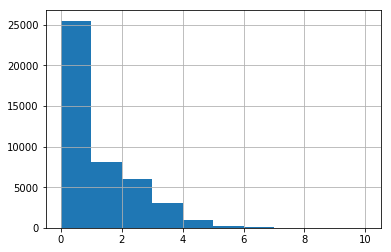

In [14]:
df['Rated Exposure'].hist(bins=10)

## Overdue Payments

32,414 clients have no overdue payments whatsoever. 9,722 have at least one payment overdue 30-59 days, 3,967 at least one overdue 60-89 days, and 4,704 at least one overdue 90+ days. 173 clients have exactly 98 payments overdue in each category, an anomaly that might indicate an error in the collection/representation.

Naively, there appears to be strong correlations between the numbers of payments in these various buckets, but those relationships largely disappear when the anomolous clients (# of outstanding payments >= 96) are removed from the analysis.

In [15]:
od1 = df.columns[4]
od2 = df.columns[5]
od3 = df.columns[6]
temp = df[(df[od1]==0) & (df[od2]==0) & (df[od3]==0)]
temp.shape

(32414, 8)

In [16]:
temp = df[df[od1]>=1]
temp.shape

(9722, 8)

In [17]:
temp = df[df[od2]>=1]
temp.shape

(3967, 8)

In [18]:
temp = df[df[od3]>=1]
temp.shape

(4704, 8)

In [19]:
temp = df[(df[od1]==98) & (df[od2]==98) & (df[od3]==98)]
temp.shape

(173, 8)

In [20]:
df[od1].value_counts()

0     35341
1      5776
2      2084
3       897
4       432
5       198
98      173
6        98
7        33
8        13
9         6
96        5
10        3
12        2
13        1
11        1
Name: # Overdue 30-59 Days, dtype: int64

In [21]:
df[od2].value_counts()

0     41096
1      2761
2       694
3       210
98      173
4        74
5        27
6        14
7         7
96        5
11        1
8         1
Name: # Overdue 60-89 Days, dtype: int64

In [22]:
df[od3].value_counts()

0     40359
1      2655
2       980
3       448
4       214
98      173
5        96
6        56
7        33
8        15
9        15
10        5
96        5
11        3
13        2
15        1
12        1
14        1
17        1
Name: # Overdue 90+ Days, dtype: int64

In [23]:
temp = df[df[od1]<96]
temp[[od1, od2, od3]].corr()

,# Overdue 30-59 Days,# Overdue 60-89 Days,# Overdue 90+ Days
# Overdue 30-59 Days,1.000,0.332,0.243
# Overdue 60-89 Days,0.332,1.000,0.329
# Overdue 90+ Days,0.243,0.329,1.000


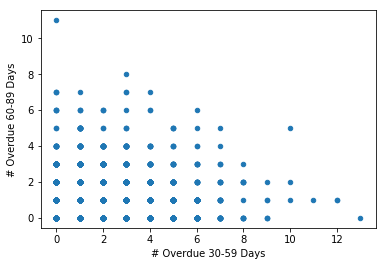

In [24]:
temp.plot.scatter(x=od1, y=od2)

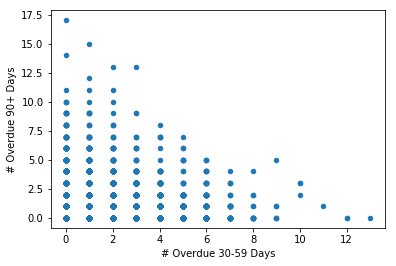

In [25]:
temp.plot.scatter(x=od1, y=od3)

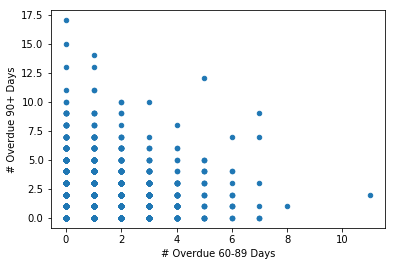

In [26]:
temp.plot.scatter(x=od2, y=od3)

## Serious Delinquencies

10,026 clients have had a serious delinquency in the past 2 years. No client has had more than 1 such delinquency. It is somewhat noteworthy that the clients with a delinquency on their record have lower average debt ratios and higher average credit ratings than those with no delinquencies, though the median average debt ratio is higher in the former case.

In [27]:
sd = df.columns[7]
df[sd].value_counts()

0    35037
1    10026
Name: Serious Delinquencies in past 2 years, dtype: int64

In [28]:
df.groupby(sd).mean()

,Age,Monthly Revenue,Debt Ratio,Rated Exposure,# Overdue 30-59 Days,# Overdue 60-89 Days,# Overdue 90+ Days
Serious Delinquencies in past 2 years,,,,,,,
0,52.723,6696.883,368.357,0.744,0.282,0.128,0.136
1,45.927,5630.826,295.121,0.948,2.388,1.828,2.091


In [29]:
one_delinq = df[df[sd]==1]
zero_delinq = df[df[sd]==0]

In [30]:
one_delinq.describe()

,Age,Monthly Revenue,Debt Ratio,Rated Exposure,# Overdue 30-59 Days,# Overdue 60-89 Days,# Overdue 90+ Days,Serious Delinquencies in past 2 years
count,10026.000,8357.000,10026.000,9847.000,10026.000,10026.000,10026.000,10026.000
mean,45.927,5630.826,295.121,0.948,2.388,1.828,2.091,1.000
std,12.916,6171.720,1238.360,1.219,11.735,11.753,11.763,0.000
min,21.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
25%,36.000,2963.000,0.194,0.000,0.000,0.000,0.000,1.000
50%,45.000,4500.000,0.428,0.000,0.000,0.000,0.000,1.000
75%,54.000,6800.000,0.892,2.000,2.000,1.000,1.000,1.000
max,101.000,250000.000,38793.000,8.000,98.000,98.000,98.000,1.000


In [31]:
zero_delinq.describe()

,Age,Monthly Revenue,Debt Ratio,Rated Exposure,# Overdue 30-59 Days,# Overdue 60-89 Days,# Overdue 90+ Days,Serious Delinquencies in past 2 years
count,35037.000,28063.000,35037.000,34099.000,35037.000,35037.000,35037.000,35037.000
mean,52.723,6696.883,368.357,0.744,0.282,0.128,0.136,0.000
std,14.768,13988.810,2718.684,1.100,2.968,2.921,2.928,0.000
min,21.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,42.000,3401.000,0.171,0.000,0.000,0.000,0.000,0.000
50%,52.000,5416.000,0.362,0.000,0.000,0.000,0.000,0.000
75%,63.000,8323.500,0.840,1.000,0.000,0.000,0.000,0.000
max,107.000,1794060.000,326442.000,10.000,98.000,98.000,98.000,0.000


# Cleaning up the Data

For the purpose of our analysis, I think it reasonable to sanitize the data by eliminating some of the outlying points. Namely:

- Clients with revenue in excess of $100,000
- Clients with debt ratios in excess of 10,000
- Clients with either 96 or 98 overdue payments in each of the given time frames

After imposing these restrictions, we are left with 44,885 data points out of the original 45,063.

In [32]:
mr = df.columns[1]
dr = df.columns[2]
od1 = df.columns[4]
od2 = df.columns[5]
od3 = df.columns[6]
clean = df[(df[mr]<=100000) | (df[mr].isna())]
clean = df[df[dr] <= 10000]
clean = df[(df[od1] < 96) & (df[od2] < 96) & (df[od3] < 96)]
clean.shape

(44885, 8)


# Dealing with Missing Data

## Monthly Revenue

With the data sanitized as above, we are left with no revenue figures for 8,643 clients. We need to first decide whether a) these clients should simply be excluded from the model or b) these clients should be assigned an estimated revenue for incorporation in the model.

If these clients were excluded from the model, we would still retain 80.8% of our data points, which we may ultimately deem an acceptable loss rate.

If we break the data set into two parts, and analyze the clients reporting revenue separately from those missing revenue, as demonstrated below, we see that the clients missing revenue have significantly higher mean and median debt ratios, lower average credit ratings, and higher average numbers of overdue payments. Given this divergence, and given that we don't much transparency into the precise relationships between the revenue figures and the balance sheets and credit ratios, I am reluctant to infer a "reasonable" estimate for the missing revenues. My instinct would be to exclude those clients from the model.

In [33]:
mr = df.columns[1]
missing_rev = clean[clean[mr].isna()]
missing_rev.describe()

,Age,Monthly Revenue,Debt Ratio,Rated Exposure,# Overdue 30-59 Days,# Overdue 60-89 Days,# Overdue 90+ Days,Serious Delinquencies in past 2 years
count,8563.000,0.000,8563.000,7465.000,8563.000,8563.000,8563.000,8563.000
mean,55.252,nan,1730.838,0.338,0.274,0.107,0.180,0.188
std,15.481,nan,5371.221,0.839,0.766,0.431,0.700,0.390
min,21.000,nan,0.000,0.000,0.000,0.000,0.000,0.000
25%,44.000,nan,161.500,0.000,0.000,0.000,0.000,0.000
50%,56.000,nan,1167.000,0.000,0.000,0.000,0.000,0.000
75%,66.000,nan,2409.500,0.000,0.000,0.000,0.000,0.000
max,107.000,nan,326442.000,7.000,10.000,7.000,9.000,1.000


In [34]:
missing_rev.corr()

,Age,Monthly Revenue,Debt Ratio,Rated Exposure,# Overdue 30-59 Days,# Overdue 60-89 Days,# Overdue 90+ Days,Serious Delinquencies in past 2 years
Age,1.000,nan,-0.017,-0.134,-0.110,-0.130,-0.147,-0.269
Monthly Revenue,nan,nan,nan,nan,nan,nan,nan,nan
Debt Ratio,-0.017,nan,1.000,0.055,0.054,-0.001,-0.022,-0.000
Rated Exposure,-0.134,nan,0.055,1.000,0.047,0.033,0.015,0.037
# Overdue 30-59 Days,-0.110,nan,0.054,0.047,1.000,0.358,0.244,0.377
# Overdue 60-89 Days,-0.130,nan,-0.001,0.033,0.358,1.000,0.350,0.361
# Overdue 90+ Days,-0.147,nan,-0.022,0.015,0.244,0.350,1.000,0.409
Serious Delinquencies in past 2 years,-0.269,nan,-0.000,0.037,0.377,0.361,0.409,1.000


In [35]:
has_rev = clean[clean[mr]>=0]
has_rev.describe()

,Age,Monthly Revenue,Debt Ratio,Rated Exposure,# Overdue 30-59 Days,# Overdue 60-89 Days,# Overdue 90+ Days,Serious Delinquencies in past 2 years
count,36322.000,36322.000,36322.000,36322.000,36322.000,36322.000,36322.000,36322.000
mean,50.333,6463.170,28.702,0.884,0.387,0.122,0.186,0.228
std,14.254,12653.233,447.194,1.161,0.913,0.472,0.715,0.419
min,21.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,40.000,3300.000,0.147,0.000,0.000,0.000,0.000,0.000
50%,50.000,5167.000,0.305,0.000,0.000,0.000,0.000,0.000
75%,60.000,8000.000,0.502,2.000,0.000,0.000,0.000,0.000
max,103.000,1794060.000,49112.000,10.000,13.000,11.000,17.000,1.000


In [36]:
has_rev.corr()

,Age,Monthly Revenue,Debt Ratio,Rated Exposure,# Overdue 30-59 Days,# Overdue 60-89 Days,# Overdue 90+ Days,Serious Delinquencies in past 2 years
Age,1.000,0.051,0.001,-0.200,-0.067,-0.075,-0.095,-0.167
Monthly Revenue,0.051,1.000,-0.032,0.056,-0.007,-0.018,-0.029,-0.034
Debt Ratio,0.001,-0.032,1.000,0.011,0.004,-0.003,-0.003,-0.008
Rated Exposure,-0.200,0.056,0.011,1.000,0.066,0.051,0.047,0.078
# Overdue 30-59 Days,-0.067,-0.007,0.004,0.066,1.000,0.327,0.243,0.355
# Overdue 60-89 Days,-0.075,-0.018,-0.003,0.051,0.327,1.000,0.325,0.310
# Overdue 90+ Days,-0.095,-0.029,-0.003,0.047,0.243,0.325,1.000,0.348
Serious Delinquencies in past 2 years,-0.167,-0.034,-0.008,0.078,0.355,0.310,0.348,1.000


## Rated Exposure

Having chosen to eliminate the clients for which we have no revenue figures from the analysis, we in turn have also eliminated those clients lacking credit ratings, so no further action is required.

In [37]:
re_col = has_rev.columns[3]
has_rev[re_col].value_counts()

0.000     19246
1.000      7516
2.000      5628
3.000      2766
4.000       884
5.000       209
6.000        52
7.000        13
8.000         6
10.000        1
9.000         1
Name: Rated Exposure, dtype: int64

# Conclusions

A cursory look at a matrix of correlation coefficients yield few really striking relationships, the strongest being those among the various overdue payment categories and the likelihood of serious delinquency (indicating, unsurprisingly, that clients with overdue payments of some duration are likely to have overdue payments of other duration and vice versa). However, I think the following assertions are generally supported by the data:

- There is positive correlation between between revenue and credit rating
- There is negative correlation between debt ratio and both revenue and credit rating
- There is slight positive correlation between credit rating and likelihood of overdue payment and delinquency
- There is strong correlation between overdue payments and serious delinquency
- There is a slight negative correlation between the age of the company and the likelihood of overdue payments and delinquency

In [38]:
has_rev.corr()

,Age,Monthly Revenue,Debt Ratio,Rated Exposure,# Overdue 30-59 Days,# Overdue 60-89 Days,# Overdue 90+ Days,Serious Delinquencies in past 2 years
Age,1.000,0.051,0.001,-0.200,-0.067,-0.075,-0.095,-0.167
Monthly Revenue,0.051,1.000,-0.032,0.056,-0.007,-0.018,-0.029,-0.034
Debt Ratio,0.001,-0.032,1.000,0.011,0.004,-0.003,-0.003,-0.008
Rated Exposure,-0.200,0.056,0.011,1.000,0.066,0.051,0.047,0.078
# Overdue 30-59 Days,-0.067,-0.007,0.004,0.066,1.000,0.327,0.243,0.355
# Overdue 60-89 Days,-0.075,-0.018,-0.003,0.051,0.327,1.000,0.325,0.310
# Overdue 90+ Days,-0.095,-0.029,-0.003,0.047,0.243,0.325,1.000,0.348
Serious Delinquencies in past 2 years,-0.167,-0.034,-0.008,0.078,0.355,0.310,0.348,1.000
